# DS207: Spotify Genre Classification Project
#### SEC2 - Nicholas Lin, Yoni Nackash, Rex Gao

## Introduction & Context

asdf

## Data Preprocessing

In [1]:
# Import the libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

pd.set_option('display.max_columns', None)

2024-04-10 21:24:13.516276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#loading the data
raw_df = pd.read_csv('data/spotify_tracks_dataset.csv')
raw_df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
df = raw_df.copy()
print('Shape of dataframe:', df.shape)

# Remove null row
print('Step 1: Removing rows with NA')
df.dropna(inplace=True)

# Map explicit field to binary
df['explicit'] = df['explicit'].apply(lambda x: 1 if x == True else 0)

# Remove "Unnamed: 0" field, and remove any duplicate tracks
print("Step 2: Drop 'Unnamed: 0' column, and remove duplicate tracks")
df = df.drop(columns = ["Unnamed: 0"])
df = df.drop_duplicates()

# Keep tracks with only 1 labeled genre
print('Step 3: Drop tracks with more than one assigned genre')
num_tracks_ids = df['track_id'].value_counts()
single_tracks_ids = num_tracks_ids[num_tracks_ids==1].index.tolist()
df = df[df['track_id'].isin(single_tracks_ids)]

# With duplicate tracks and tracks with multiple genres removed, drop unnecessary columns for classification
print("Step 4: Drop columns not needed for classification: 'track_id', 'artists', 'album_name','track_name','time_signature'")
df = df.drop(columns = ["track_id", "artists", "album_name","track_name","time_signature"])

print('Shape of dataframe:', df.shape)

Shape of dataframe: (114000, 21)
Step 1: Removing rows with NA
Step 2: Drop 'Unnamed: 0' column, and remove duplicate tracks
Step 3: Drop tracks with more than one assigned genre
Step 4: Drop columns not needed for classification: 'track_id', 'artists', 'album_name','track_name','time_signature'
Shape of dataframe: (73441, 15)


## EDA

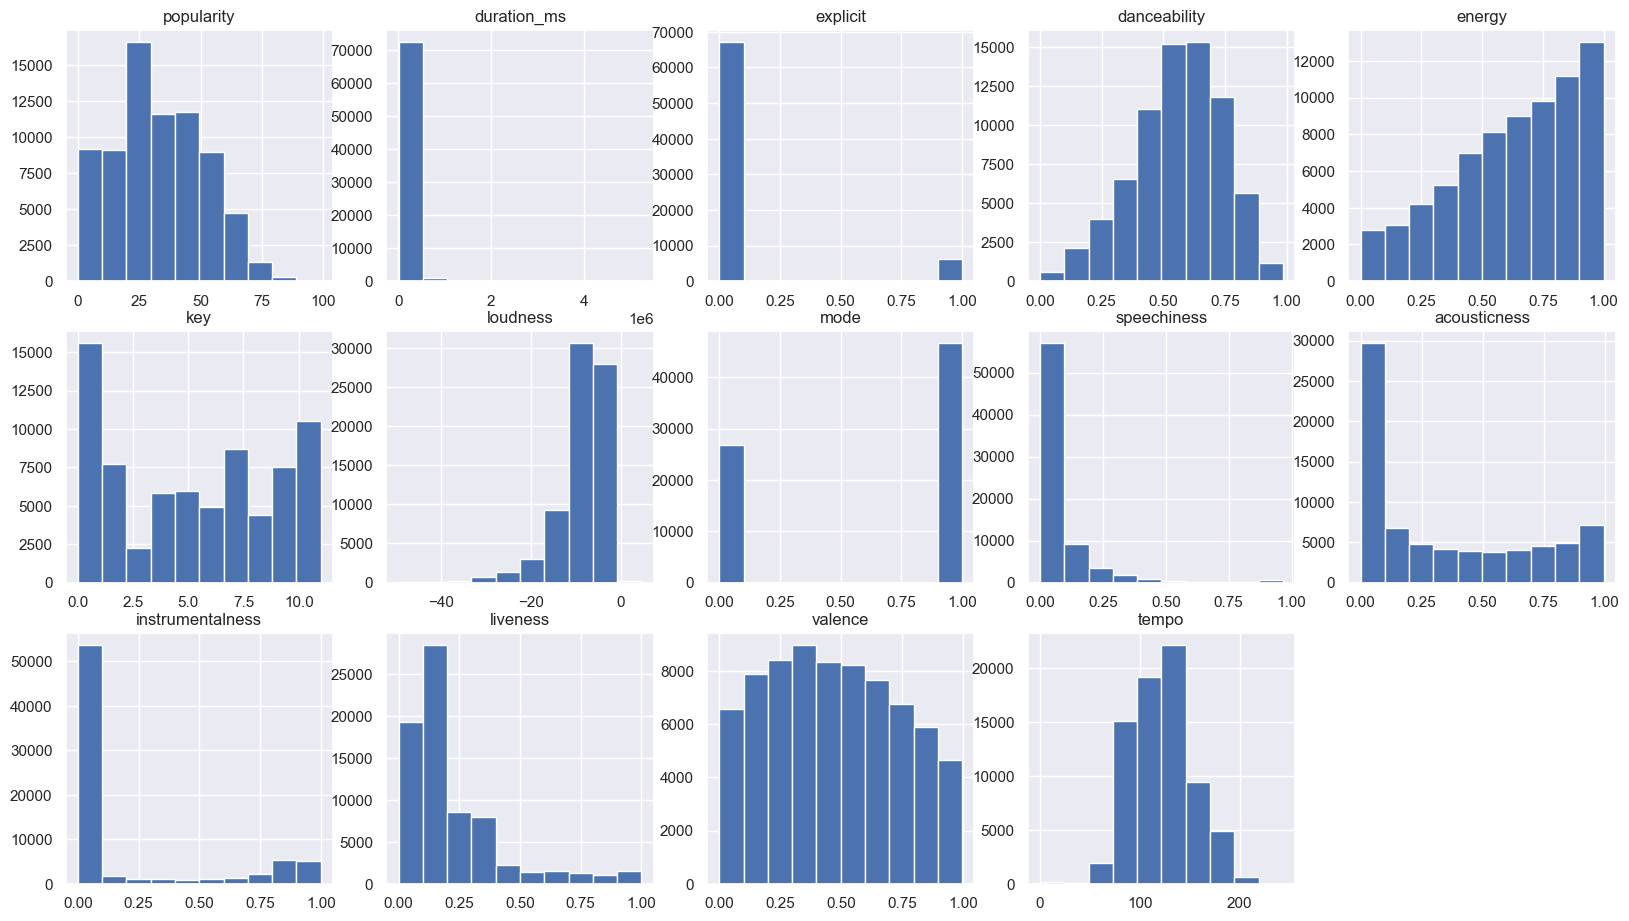

In [5]:
#Plotting feature histograms
features = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(20, 15))
for i in range(len(features)):
  plt.subplot(4, 5, i+1)
  plt.hist(np.array(df[features[i]]))
  plt.title(features[i])
plt.show()

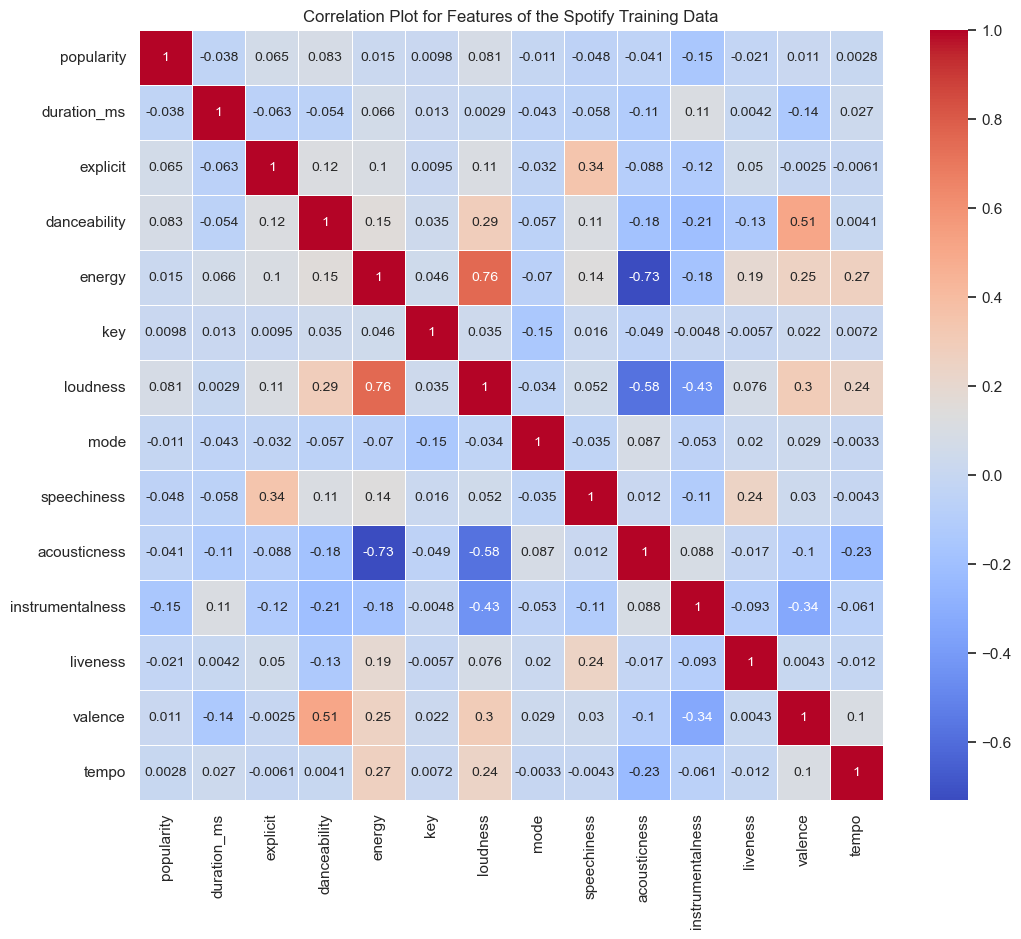

In [6]:
#Plotting correlation plot of the features
plt.figure(figsize=(12,10))
corr = df[features].corr()
sns.heatmap(corr, annot = True, cmap= 'coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Plot for Features of the Spotify Training Data')

plt.show()

## Feature Engineering

In [7]:
# One hot encode key field
df = pd.get_dummies(df, columns=['key'], dtype=int)
df = df.rename(columns={"key_0":"C","key_1":"C#","key_2":"D","key_3":"D#","key_4":"E","key_5":"F",
                        "key_6":"F#","key_7":"G","key_8":"G#","key_9":"A","key_10":"A#","key_11":"B"})

df['popularity'] = df['popularity'].astype(int)
df['duration_ms'] = df['duration_ms'].astype(int)
df['mode'] = df['mode'].astype(int)

print(df.shape)
df.head()

(73441, 26)


,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
2,57,210826,0,0.438,0.3590,-9.734,1,0.0557,0.210,0.000000,0.1170,0.120,76.332,acoustic,1,0,0,0,0,0,0,0,0,0,0,0
3,71,201933,0,0.266,0.0596,-18.515,1,0.0363,0.905,0.000071,0.1320,0.143,181.740,acoustic,1,0,0,0,0,0,0,0,0,0,0,0
4,82,198853,0,0.618,0.4430,-9.681,1,0.0526,0.469,0.000000,0.0829,0.167,119.949,acoustic,0,0,1,0,0,0,0,0,0,0,0,0
8,74,189613,0,0.625,0.4140,-8.700,1,0.0369,0.294,0.000000,0.1510,0.669,130.088,acoustic,1,0,0,0,0,0,0,0,0,0,0,0
10,74,244800,0,0.627,0.3630,-8.127,1,0.0291,0.279,0.000000,0.0928,0.301,99.905,acoustic,0,0,0,0,0,0,0,0,1,0,0,0


In [8]:
# Bin the popularity field
df['popularity_bin'] = pd.qcut(df.popularity,q=5,labels=[1,2,3,4,5])
df = pd.get_dummies(df, columns=['popularity_bin'], dtype=int)

# Remove tracks that are less than 60 seconds
df = df[df['duration_ms'] > 60000]

# Keep tracks with duration within 98th percentile
df = df[df['duration_ms'] < df['duration_ms'].quantile(.98)]

# Bin the duration_ms field
df['duration_bin'] = pd.qcut(df.duration_ms,q=4,labels=[1,2,3,4])
df = pd.get_dummies(df, columns=['duration_bin'], dtype=int)
df

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,popularity_bin_1,popularity_bin_2,popularity_bin_3,popularity_bin_4,popularity_bin_5,duration_bin_1,duration_bin_2,duration_bin_3,duration_bin_4
2,57,210826,0,0.438,0.3590,-9.734,1,0.0557,0.210,0.000000,0.1170,0.1200,76.332,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,71,201933,0,0.266,0.0596,-18.515,1,0.0363,0.905,0.000071,0.1320,0.1430,181.740,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,82,198853,0,0.618,0.4430,-9.681,1,0.0526,0.469,0.000000,0.0829,0.1670,119.949,acoustic,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
8,74,189613,0,0.625,0.4140,-8.700,1,0.0369,0.294,0.000000,0.1510,0.6690,130.088,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
10,74,244800,0,0.627,0.3630,-8.127,1,0.0291,0.279,0.000000,0.0928,0.3010,99.905,acoustic,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0,0.172,0.2350,-16.393,1,0.0422,0.640,0.928000,0.0863,0.0339,125.995,world-music,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
113996,22,385000,0,0.174,0.1170,-18.318,0,0.0401,0.994,0.976000,0.1050,0.0350,85.239,world-music,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
113997,22,271466,0,0.629,0.3290,-10.895,0,0.0420,0.867,0.000000,0.0839,0.7430,132.378,world-music,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
113998,41,283893,0,0.587,0.5060,-10.889,1,0.0297,0.381,0.000000,0.2700,0.4130,135.960,world-music,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1


## Feature Selection

In [9]:
# Set features to use in model
features = [
    # 'popularity',
    # 'duration_ms',
    'explicit',
    'danceability',
    'energy',
    'loudness',
    # 'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    # 'C',
    # 'C#',
    # 'D',
    # 'D#',
    # 'E',
    # 'F',
    # 'F#',
    # 'G',
    # 'G#',
    # 'A',
    # 'A#',
    # 'B',
    'popularity_bin_1',
    'popularity_bin_2',
    'popularity_bin_3',
    'popularity_bin_4',
    'popularity_bin_5',
    'duration_bin_1',
    'duration_bin_2',
    'duration_bin_3',
    'duration_bin_4'
]

# Load tracks and genre labels
tracks = df[features]
labels = df['track_genre']
labels_count = len(labels.unique())

print("Shape of tracks ", tracks.shape)
print("Shape of labels ", labels.shape)

Shape of tracks  (71256, 19)
Shape of labels  (71256,)


## Data Shuffling

In [10]:
# Apply random shufflying to training examples.
np.random.seed(4)
indices = np.arange(tracks.shape[0])
shuffled_indices = np.random.permutation(indices)
tracks = tracks.iloc[shuffled_indices]
labels = labels.iloc[shuffled_indices]

## Data Normalizing - Does normalizing need to be done after split for proper train/test normalization?

In [11]:
# Encode the target variable
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Normalize the feature set
scaler = StandardScaler()
tracks_scaled = scaler.fit_transform(tracks)

## Data Splitting

In [13]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(tracks_scaled, labels_encoded, test_size = 0.2, random_state=42)

# Print shapes of train and test data 
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', Y_train.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', Y_test.shape)

print('Check for any null values:', np.isnan(X_train).sum() + np.isnan(Y_train).sum() + np.isnan(X_test).sum() + np.isnan(Y_test).sum())

Shape of train images  (57004, 19)
Shape of train labels  (57004,)
Shape of test images  (14252, 19)
Shape of test labels  (14252,)
Check for any null values: 0


## Baseline Model

In [14]:
#show class distribution
unique, counts = np.unique(Y_train, return_counts = True)
class_counts = dict(zip(unique, counts))
class_counts

{0: 655,
 1: 727,
 2: 119,
 3: 123,
 4: 547,
 5: 523,
 6: 640,
 7: 760,
 8: 304,
 9: 212,
 10: 705,
 11: 438,
 12: 708,
 13: 669,
 14: 692,
 15: 466,
 16: 434,
 17: 774,
 18: 726,
 19: 704,
 20: 353,
 21: 531,
 22: 517,
 23: 402,
 24: 642,
 25: 495,
 26: 654,
 27: 740,
 28: 158,
 29: 227,
 30: 99,
 31: 269,
 32: 538,
 33: 436,
 34: 328,
 35: 710,
 36: 664,
 37: 398,
 38: 612,
 39: 483,
 40: 483,
 41: 610,
 42: 647,
 43: 402,
 44: 597,
 45: 692,
 46: 616,
 47: 302,
 48: 540,
 49: 737,
 50: 774,
 51: 427,
 52: 758,
 53: 159,
 54: 751,
 55: 408,
 56: 101,
 57: 206,
 58: 643,
 59: 666,
 60: 572,
 61: 724,
 62: 275,
 63: 294,
 64: 351,
 65: 622,
 66: 709,
 67: 190,
 68: 111,
 69: 797,
 70: 711,
 71: 117,
 72: 570,
 73: 459,
 74: 354,
 75: 636,
 76: 659,
 77: 521,
 78: 645,
 79: 575,
 80: 321,
 81: 519,
 82: 670,
 83: 481,
 84: 403,
 85: 162,
 86: 185,
 87: 319,
 88: 69,
 89: 57,
 90: 221,
 91: 519,
 92: 510,
 93: 728,
 94: 448,
 95: 766,
 96: 522,
 97: 661,
 98: 678,
 99: 566,
 100: 733,
 1

In [15]:
#stratified baseline implementation
dummy_clf = DummyClassifier(strategy = 'stratified', random_state = 42)
dummy_clf.fit(X_train, Y_train)
Y_pred = dummy_clf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)

print(f'Baseline Classifier Accuracy: {accuracy}')
print(f'Classification Report: {report}')

Baseline Classifier Accuracy: 0.010735335391523996
Classification Report:               precision    recall  f1-score   support

           0       0.01      0.01      0.01       164
           1       0.00      0.00      0.00       185
           2       0.00      0.00      0.00        40
           3       0.00      0.00      0.00        35
           4       0.02      0.02      0.02       146
           5       0.00      0.00      0.00       129
           6       0.01      0.01      0.01       143
           7       0.02      0.02      0.02       195
           8       0.01      0.01      0.01        79
           9       0.00      0.00      0.00        57
          10       0.01      0.01      0.01       175
          11       0.00      0.00      0.00       115
          12       0.02      0.02      0.02       165
          13       0.01      0.01      0.01       160
          14       0.03      0.02      0.02       195
          15       0.01      0.01      0.01       118
       

## KNN

## Clustering

At this point, we have recognized that our list of unique genres may actually contain a hierarchy, with some "parent" genres, as well as "children" sub-genres. As an example, Alt-rock, Punk-rock, and Hard-rock can all reasonably be considered sub-genres of Rock. The significant number of genres will most likely prove difficult to classify, and therefore we will reduce the number of unique genres through aggregation. For our first attempt at genre aggregation, we performed a clustering activity.

/Users/yoninackash/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


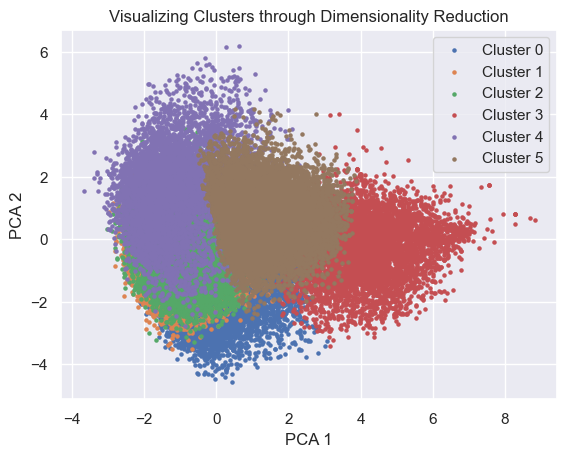

In [146]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prepare data for clustering
cluster_data = df.drop(columns=['track_genre'])[['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo']]

scaled_features = scaler.fit_transform(cluster_data)

# Define number of clusters 
number_of_clusters = 6
kmeans = KMeans(n_clusters = number_of_clusters, random_state = 48)
cluster_data['cluster'] = kmeans.fit_predict(scaled_features)

#Principal component analysis (dimensionality reduction) for visualisation
pca = PCA(n_components=2)
cluster_reduced = pca.fit_transform(scaled_features)

# Visualize the clusters through a scatter plot
for i in range(number_of_clusters):
    idx = cluster_data['cluster'] == i
    plt.scatter(cluster_reduced[idx, 0], cluster_reduced[idx, 1], label=f'Cluster {i}', alpha = 1, s=5)

plt.title('Visualizing Clusters through Dimensionality Reduction')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

<Axes: xlabel='cluster'>

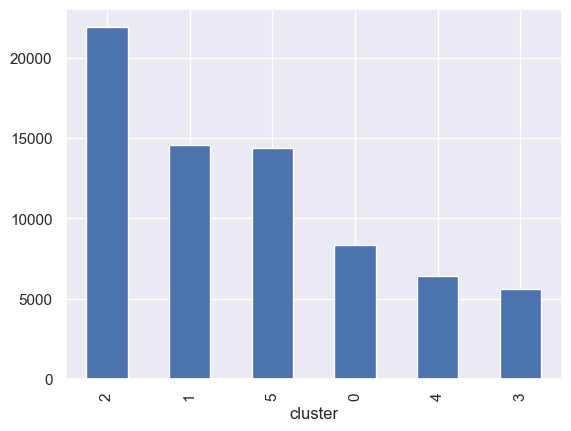

In [144]:
cluster_data['cluster'].value_counts().plot(kind = 'bar')

In [145]:
print('Number of unique genres in')
for i in range(number_of_clusters):
    print('Cluster',i,':',len(df[cluster_data['cluster']==i]['track_genre'].unique()))

Number of unique genres in
Cluster 0 : 94
Cluster 1 : 112
Cluster 2 : 112
Cluster 3 : 60
Cluster 4 : 103
Cluster 5 : 109


Taking a deeper look at our clustering activity, it appears that most genres are present across multiple clusters. This held true while experimenting with different cluster sizes. The clustering was unable to isolate genres into single clusters. While the clusters may contain tracks with similar characteristics, this does not necessarily seem to be a "genre classification" activity. This makes reasonable sense, as this is unsupervised learning, and we are not providing the genre labels. However, we are interested in testing if it is possible to build a model that will learn the characteristics and relationships within specific genres. Therefore, we have decided not to move forward with the genre aggregation created through clustering.

## Research & Manual Genre Mapping

After some research and investigation, we decided to create a manual genre hierarchy mapping. For this mapping, we focused our attention on several of the most prolific genres, as defined in several [resources](https://rateyourmusic.com/genres/). [ADD KAGGLE AS A RESOURCE.] These categories include: Rock, Pop, Electronic Dance Music, Hip-Hop/R&B, Country, Latin & Reggaeton, and Classical. 

In [148]:
genre_to_category = {
    # EDM
    'edm': 'Electronic Dance Music', 
    'techno': 'Electronic Dance Music', 
    'drum-and-bass': 'Electronic Dance Music', 
    'progressive-house': 'Electronic Dance Music', 
    
    # Rock
    'alt-rock': 'Rock', 
    'rock': 'Rock', 
    'punk': 'Rock', 
    'hard-rock': 'Rock', 
    'metal': 'Rock', 
    'heavy-metal': 'Rock', 
    
    # Hip-Hop and R&B
    'hip-hop': 'Hip-Hop and R&B', 
    'r-n-b': 'Hip-Hop and R&B', 
    'funk': 'Hip-Hop and R&B',
    'trap': 'Hip-Hop and R&B',

    # Country
    'country': 'Country',
    'bluegrass': 'Country',
    'honky-tonk': 'Country',

    # Classical
    'classical': 'Classical', 
    'opera': 'Classical', 
    
    # Pop
    'pop': 'Pop', 
    'k-pop': 'Pop', 
    'pop-film': 'Pop', 
    
    # Latin & Reggaeton
    'latin': 'Latin & Reggaeton', 
    'latino': 'Latin & Reggaeton', 
    'reggaeton': 'Latin & Reggaeton', 
    'salsa': 'Latin & Reggaeton',
    'samba': 'Latin & Reggaeton', 
}

# Map each track to a category
df['music_category'] = df['track_genre'].apply(lambda x: genre_to_category.get(x, 'Other'))

slim_df = df[df['music_category'] != 'Other']
slim_df.shape

(13578, 36)

### [YN Note] - currently updating df and then recreating tracks & labels. This means then need to reshuffle, normalize and split again. Is there a better alternative? Labels was previously encoded, how would we map the new music categories to it, and remove "other" ? If we decide to just reshuffle, normalize, split, maybe we create functions above to minimize duplicate code? 

<Axes: ylabel='music_category'>

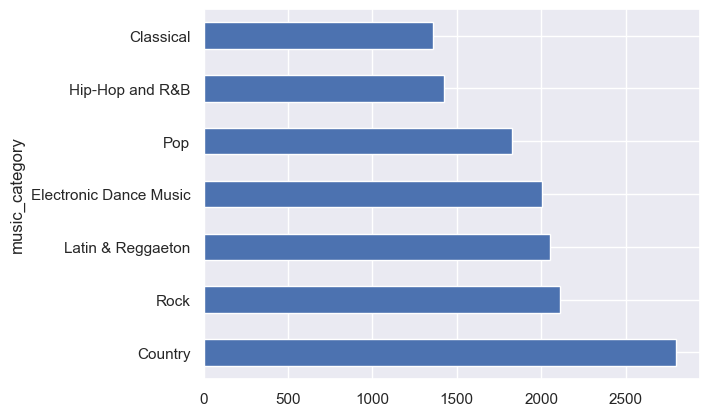

In [153]:
slim_df['music_category'].value_counts().plot(kind='barh')

In [158]:
slim_df['music_category'].value_counts()

music_category
Country                   2799
Rock                      2112
Latin & Reggaeton         2051
Electronic Dance Music    2002
Pop                       1829
Hip-Hop and R&B           1426
Classical                 1359
Name: count, dtype: int64

It appears we do not have an even distribution of tracks across our new music categories. To remedy this, we will reduce each category to be uniform with the size of the smallest category (Classical, 1359 samples).

In [160]:
# Load tracks and genre labels
tracks = slim_df[features]
labels = slim_df['music_category']
labels_count = len(labels.unique())

print("Shape of tracks ", tracks.shape)
print("Shape of labels ", labels.shape)

# Apply random shufflying to training examples.
np.random.seed(4)
indices = np.arange(tracks.shape[0])
shuffled_indices = np.random.permutation(indices)
tracks = tracks.iloc[shuffled_indices]
labels = labels.iloc[shuffled_indices]

Shape of tracks  (13578, 19)
Shape of labels  (13578,)


## Class Distribution Fixing

In [162]:
min_count = labels.value_counts().min()
result = {}
unique_classes = np.unique(labels)
for value in unique_classes:
    indices = np.where(labels==value)[0][:min_count]
    result[value] = indices.tolist()
index_values = list(result.values())
index_values = [element for nestedlist in index_values for element in nestedlist]
tracks = tracks.iloc[index_values]
labels = labels.iloc[index_values]

<Axes: >

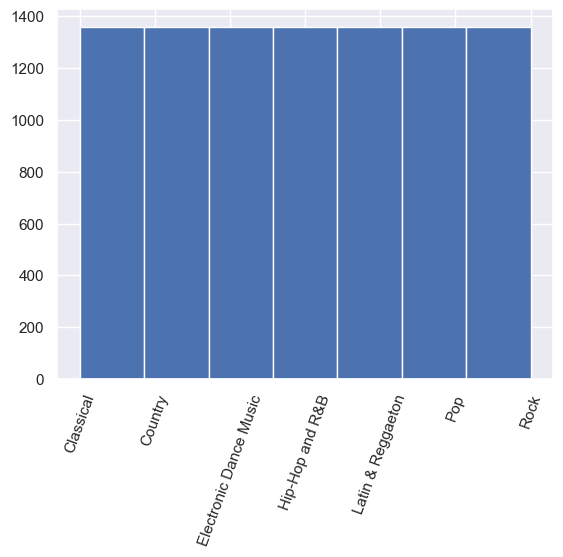

In [169]:
labels.hist(bins=labels_count,xrot=70)

In [170]:
# Encode the target variable
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Normalize the feature set
scaler = StandardScaler()
tracks_scaled = scaler.fit_transform(tracks)

In [171]:
#Resplit
X_train, X_test, Y_train, Y_test = train_test_split(tracks_scaled, labels_encoded, test_size = 0.2, random_state=42)

# Print shapes of train and test data 
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', Y_train.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', Y_test.shape)

print('Check for any null values:', np.isnan(X_train).sum() + np.isnan(Y_train).sum() + np.isnan(X_test).sum() + np.isnan(Y_test).sum())

Shape of train images  (7610, 19)
Shape of train labels  (7610,)
Shape of test images  (1903, 19)
Shape of test labels  (1903,)
Check for any null values: 0


## KNN Revisted

## Decision Trees

#### NEED TO CREATE VALIDATION DATA, JUST USING TEST DATA FOR NOW

Model Accuracy on training set: 0.78
Model Accuracy on TESTING set [NEED TO CREATE VAL DATA!!!]: 0.72


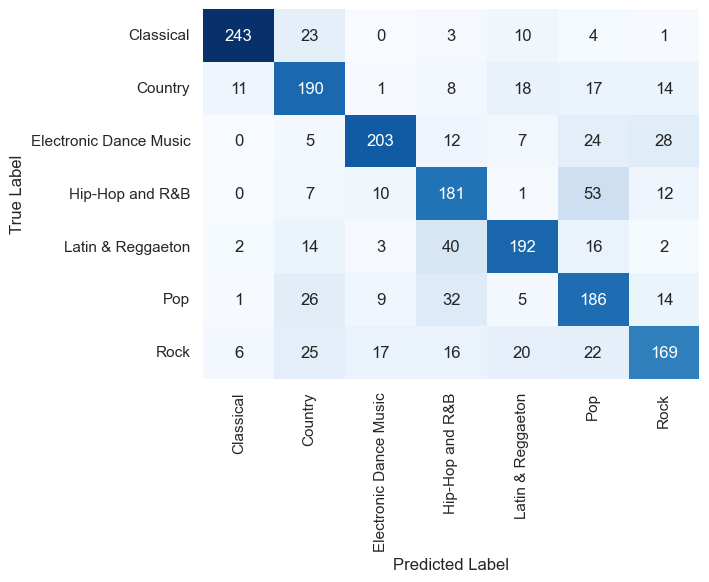

In [196]:
# Build RandomForestClassifier, and fit with X_Train_re, y_train
rf = RandomForestClassifier(
    n_estimators=17,
    n_jobs=1,
    random_state=7,
    max_depth=8,
    # max_features='log2'
)
rf.fit(X_train, Y_train)

# Evaluate model accuracy with X_train_re
print('Model Accuracy on training set:',round(rf.score(X_train, Y_train),2))  

# Evaluate model accuracy with X_val_re
print('Model Accuracy on TESTING set [NEED TO CREATE VAL DATA!!!]:',round(rf.score(X_test, Y_test),2))

# Plot Confusion Matrix using y_val, y_val_pred
Y_Test_pred = rf.predict(X_test)
cm = confusion_matrix(Y_test, Y_Test_pred)
ax = sns.heatmap(cm, annot=True, fmt='.3g', cmap='Blues', xticklabels=labels.unique(), yticklabels=labels.unique(), cbar=False)
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

## Neural Networks

In [198]:
def build_model(num_features, n_classes,learning_rate=0.01):
    """Build a TF logistic regression model using Keras.
    
    Args:
    learning_rate: The desired learning rate for SGD.
    
    Returns:
    model: A tf.keras model (graph).
    """
    # Random Seed + Clear Session
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Build a model using keras.Sequential.
    model = keras.Sequential(name = 'Genres')
    
    # Keras layers processing
    model.add(tf.keras.layers.InputLayer(input_shape=num_features))

    #adding extra layer
    model.add(keras.layers.Dense(
            units=256,
            activation = 'relu'))
    
    # This layer constructs the linear set of parameters for each input feature
    # (as well as a bias), and applies a sigmoid to the result. The result is
    # binary logistic regression.
    model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'))

    # Use the SGD optimizer as usual.
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # We specify the binary_crossentropy loss (equivalent to log loss).
    # Notice that we are including 'binary accuracy' as one of the metrics that we
    # ask Tensorflow to report when evaluating the model.
    model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])
    
    return model

In [199]:
model = build_model(num_features = X_train.shape[1], n_classes = labels_count)
model.summary()

Model: "Genres"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5120      
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 6,919
Trainable params: 6,919
Non-trainable params: 0
_________________________________________________________________


2024-04-10 23:36:01.015383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [200]:
# Fit the model.
history = model.fit(
  x = X_train,   # training examples
  y = Y_train,   #labels
  epochs=10,             # number of passes through the training data
  batch_size=128,        # mini-batch size for SGD
  validation_split=0.25, # use a fraction of the examples for validation -- DO WE STILL NEED THIS IF VALIDATION SPLIT
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

Epoch 1/10
45/45 [==============================] - 0s 3ms/step - loss: 1.8461 - accuracy: 0.2507 - val_loss: 1.7045 - val_accuracy: 0.3946
Epoch 2/10
45/45 [==============================] - 0s 956us/step - loss: 1.6283 - accuracy: 0.4486 - val_loss: 1.5227 - val_accuracy: 0.5328
Epoch 3/10
45/45 [==============================] - 0s 915us/step - loss: 1.4802 - accuracy: 0.5502 - val_loss: 1.3943 - val_accuracy: 0.5891
Epoch 4/10
45/45 [==============================] - 0s 913us/step - loss: 1.3720 - accuracy: 0.5933 - val_loss: 1.2974 - val_accuracy: 0.6248
Epoch 5/10
45/45 [==============================] - 0s 952us/step - loss: 1.2890 - accuracy: 0.6164 - val_loss: 1.2216 - val_accuracy: 0.6453
Epoch 6/10
45/45 [==============================] - 0s 914us/step - loss: 1.2237 - accuracy: 0.6315 - val_loss: 1.1612 - val_accuracy: 0.6574
Epoch 7/10
45/45 [==============================] - 0s 908us/step - loss: 1.1713 - accuracy: 0.6439 - val_loss: 1.1123 - val_accuracy: 0.6731
Epoch 8/

,loss,accuracy,val_loss,val_accuracy
0,1.846084,0.250745,1.704541,0.394640
1,1.628280,0.448572,1.522731,0.532843
2,1.480240,0.550202,1.394333,0.589070
3,1.372022,0.593306,1.297403,0.624803
4,1.288975,0.616436,1.221582,0.645297
5,1.223689,0.631505,1.161163,0.657383
6,1.171324,0.643946,1.112320,0.673148
7,1.128780,0.652882,1.072397,0.678403
8,1.093812,0.658840,1.039315,0.688912
9,1.064676,0.663921,1.011638,0.693116


In [201]:
test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0,return_dict=True)['accuracy']
print('Test Accuracy:', test_accuracy)

Test Accuracy: 0.65790855884552


60/60 [==============================] - 0s 341us/step


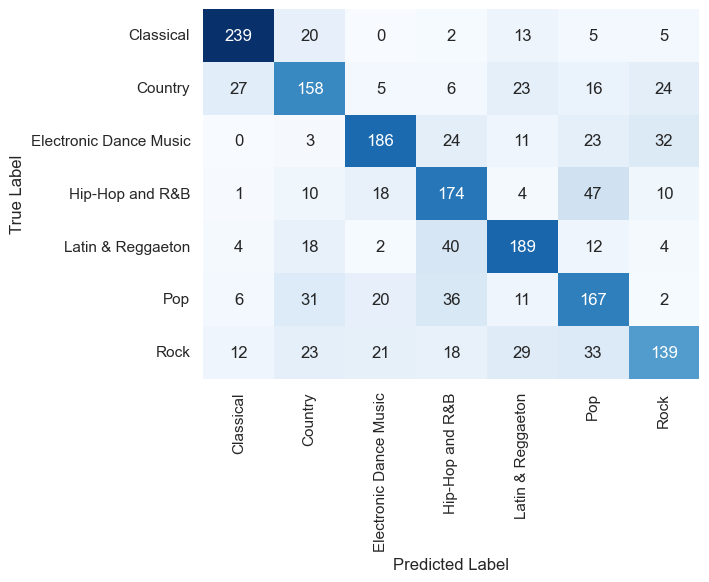

In [202]:
# Recall that model.predict gives a vector of probabilities for each x.
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions = np.argmax(model.predict(X_test), axis=-1)

# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=labels.unique(), yticklabels=labels.unique(), cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [203]:
# Calculating precision for each class
for i in range(labels_count):
    prec = tf.keras.backend.get_value(confusion_matrix[:,i][i]) / np.sum(tf.keras.backend.get_value(confusion_matrix[:,i]))
    print(round(prec,3),":",labels.unique()[i])

0.827 : Classical
0.601 : Country
0.738 : Electronic Dance Music
0.58 : Hip-Hop and R&B
0.675 : Latin & Reggaeton
0.551 : Pop
0.644 : Rock


## Conclusion